First we need to import utils package and tensorflow with addons.

In [1]:
from utils import *
import tensorflow as tf
import tensorflow_addons as tfa

set_seed(42)

2022-04-12 10:31:55.254216: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Next, we define our model. Note that reparametrization trick is done manually - it can be done with tensorflow probability package, which is doing that by itself automatically.

In [2]:
class DiagonalToZero(tf.keras.constraints.Constraint):
    def __call__(self, w):
        """Set diagonal to zero"""
        q = tf.linalg.set_diag(w, tf.zeros(w.shape[0:-1]), name=None)
        return q

class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a basket."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim), stddev=1.)
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class VASP(Model):
    class Model(tf.keras.Model):
        def __init__(self, num_words, latent=1024, hidden=1024, items_sampling=1.):
            """
            num_words             nr of items in dataset (size of tokenizer)
            latent                size of latent space
            hidden                size of hidden layers
            items_sampling        Large items datatsets can be very gpu memory consuming in EASE layer.
                                  This coefficient reduces number of ease parametrs by taking only
                                  fraction of items sorted by popularity as input for model.
                                  Note: This coef should be somewhere around coverage@100 achieved by full
                                  size model.
                                  For ML20M this coef should be between 0.4888 (coverage@100 for full model)
                                  and 1.0
                                  For Netflix this coef should be between 0.7055 (coverage@100 for full
                                  model) and 1.0
            """
            super(VASP.Model, self).__init__()

            self.sampled_items = int(num_words * items_sampling)

            assert self.sampled_items > 0
            assert self.sampled_items <= num_words

            self.s = self.sampled_items < num_words

            # ************* ENCODER ***********************
            self.encoder1 = tf.keras.layers.Dense(hidden)
            self.ln1 = tf.keras.layers.LayerNormalization()
            self.encoder2 = tf.keras.layers.Dense(hidden)
            self.ln2 = tf.keras.layers.LayerNormalization()
            self.encoder3 = tf.keras.layers.Dense(hidden)
            self.ln3 = tf.keras.layers.LayerNormalization()
            self.encoder4 = tf.keras.layers.Dense(hidden)
            self.ln4 = tf.keras.layers.LayerNormalization()
            self.encoder5 = tf.keras.layers.Dense(hidden)
            self.ln5 = tf.keras.layers.LayerNormalization()
            self.encoder6 = tf.keras.layers.Dense(hidden)
            self.ln6 = tf.keras.layers.LayerNormalization()
            self.encoder7 = tf.keras.layers.Dense(hidden)
            self.ln7 = tf.keras.layers.LayerNormalization()

            # ************* SAMPLING **********************
            self.dense_mean = tf.keras.layers.Dense(latent,
                                                    name="Mean")
            self.dense_log_var = tf.keras.layers.Dense(latent,
                                                       name="log_var")

            self.sampling = Sampling(name='Sampler')

            # ************* DECODER ***********************
            self.decoder1 = tf.keras.layers.Dense(hidden)
            self.dln1 = tf.keras.layers.LayerNormalization()
            self.decoder2 = tf.keras.layers.Dense(hidden)
            self.dln2 = tf.keras.layers.LayerNormalization()
            self.decoder3 = tf.keras.layers.Dense(hidden)
            self.dln3 = tf.keras.layers.LayerNormalization()
            self.decoder4 = tf.keras.layers.Dense(hidden)
            self.dln4 = tf.keras.layers.LayerNormalization()
            self.decoder5 = tf.keras.layers.Dense(hidden)
            self.dln5 = tf.keras.layers.LayerNormalization()

            self.decoder_resnet = tf.keras.layers.Dense(self.sampled_items,
                                                        activation='sigmoid',
                                                        name="DecoderR")
            self.decoder_latent = tf.keras.layers.Dense(self.sampled_items,
                                                        activation='sigmoid',
                                                        name="DecoderL")

            # ************* PARALLEL SHALLOW PATH *********

            self.ease = tf.keras.layers.Dense(
                self.sampled_items,
                activation='sigmoid',
                use_bias=False,
                kernel_constraint=DiagonalToZero(),  # critical to prevent learning simple identity
            )

        def call(self, x, training=None):
            sampling = self.s
            if sampling:
                sampled_x = x[:, :self.sampled_items]
                non_sampled = x[:, self.sampled_items:] * 0.
            else:
                sampled_x = x

            z_mean, z_log_var, z = self.encode(sampled_x)
            if training:
                d = self.decode(z)
                # Add KL divergence regularization loss.
                kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
                kl_loss = tf.reduce_mean(kl_loss)
                kl_loss *= -0.5
                self.add_loss(kl_loss)
                self.add_metric(kl_loss, name="kl_div")
            else:
                d = self.decode(z_mean)

            if sampling:
                d = tf.concat([d, non_sampled], axis=-1)

            ease = self.ease(sampled_x)

            if sampling:
                ease = tf.concat([ease, non_sampled], axis=-1)

            return d * ease

        def decode(self, x):
            e0 = x
            e1 = self.dln1(tf.keras.activations.swish(self.decoder1(e0)))
            e2 = self.dln2(tf.keras.activations.swish(self.decoder2(e1) + e1))
            e3 = self.dln3(tf.keras.activations.swish(self.decoder3(e2) + e1 + e2))
            e4 = self.dln4(tf.keras.activations.swish(self.decoder4(e3) + e1 + e2 + e3))
            e5 = self.dln5(tf.keras.activations.swish(self.decoder5(e4) + e1 + e2 + e3 + e4))

            dr = self.decoder_resnet(e5)
            dl = self.decoder_latent(x)

            return dr * dl

        def encode(self, x):
            e0 = x
            e1 = self.ln1(tf.keras.activations.swish(self.encoder1(e0)))
            e2 = self.ln2(tf.keras.activations.swish(self.encoder2(e1) + e1))
            e3 = self.ln3(tf.keras.activations.swish(self.encoder3(e2) + e1 + e2))
            e4 = self.ln4(tf.keras.activations.swish(self.encoder4(e3) + e1 + e2 + e3))
            e5 = self.ln5(tf.keras.activations.swish(self.encoder5(e4) + e1 + e2 + e3 + e4))
            e6 = self.ln6(tf.keras.activations.swish(self.encoder6(e5) + e1 + e2 + e3 + e4 + e5))
            e7 = self.ln7(tf.keras.activations.swish(self.encoder7(e6) + e1 + e2 + e3 + e4 + e5 + e6))

            z_mean = self.dense_mean(e7)
            z_log_var = self.dense_log_var(e7)
            z = self.sampling((z_mean, z_log_var))

            return z_mean, z_log_var, z

    def create_model(self, latent=2048, hidden=4096, ease_items_sampling=1., summary=False):
        self.model = VASP.Model(self.dataset.num_words, latent, hidden, ease_items_sampling)
        self.model(self.split.train_gen[0][0])
        if summary:
            self.model.summary()
        self.mc = MetricsCallback(self)

    def compile_model(self, lr=0.00002, fl_alpha=0.25, fl_gamma=2.0):
        """
        lr         learning rate of Nadam optimizer
        fl_alpha   alpha parameter of focal crossentropy
        fl_gamma   gamma parameter of focal crossentropy
        """
        self.model.compile(
            optimizer=tf.keras.optimizers.Nadam(lr),
            loss=lambda x, y: tfa.losses.sigmoid_focal_crossentropy(x, y, alpha=fl_alpha, gamma=fl_gamma),
            metrics=['mse', cosine_loss]
        )

    def train_model(self, epochs=150):
        self.model.fit(
            self.split.train_gen,
            validation_data=self.split.validation_gen,
            epochs=epochs,
            callbacks=[self.mc]
        )



Now, we can load previously preprocessed dataset. We also load pre-defined train/test/validation split.

In [3]:
dataset = Data(d='', pruning='u5')
dataset.splits = []
dataset.create_splits(1, 1000, shuffle=False, generators=False)
dataset.split.train_users = pd.read_json("train_users.json").userid.apply(str).to_frame()
dataset.split.validation_users = pd.read_json("val_users.json").userid.apply(str).to_frame()
dataset.split.test_users = pd.read_json("test_users.json").userid.apply(str).to_frame()
dataset.split.inference_users = pd.read_json("users_pu5.json").userid.apply(str).to_frame()
dataset.split.generators()

Reading users_pu5
Reading items_pu5
Reading purchases_txt_pu5
Reading items_sorted_pu5
Reading users_sorted_pu5
Read all in 0.3601491451263428
Tokenizer trained for 6808 items.
Creating 1 splits of 1000 samples each.
Creating split nr. 1
SplitGenerator init done in 3.9051690101623535 secs.
SplitGenerator init done in 0.13989996910095215 secs.
SplitGenerator init done in 0.13843774795532227 secs.
SplitGenerator init done in 4.191557168960571 secs.
Creating evaluator
Creating test split evaluator with leave_random_20_pct_out method.
Creating validation split evaluator with leave_random_20_pct_out method.


Now we can create an instance of our model and train it.

For validation during training we sample 80% of the user's interactions randomly as input for the model, and then we measure Recall@20, Recall@50 and NDCG@100 for predicted interactions against the remaining 20% of the user's interactions.

This method can give different results for different seeds, but since it is used for validation during training only, it's good enough.

In [4]:
dataset.split.inference_gen.data.set_index(dataset.split.inference_gen.data.userid).itemids.apply(
                lambda x: x.split(','))

userid
11        [4643, 170, 531, 616, 2140, 2722, 2313, 2688, ...
14        [8961, 1396, 471, 2105, 1042, 1947, 1269, 2394...
18        [1952, 1283, 3507, 4280, 51084, 593, 318, 356,...
25        [261, 22, 2161, 3255, 372, 1093, 428, 175, 214...
31        [260, 1196, 1210, 7153, 4993, 5952, 1270, 5855...
                                ...                        
138473    [524, 3354, 1025, 6565, 69757, 2085, 32, 55282...
138475    [1639, 1673, 1148, 246, 2019, 1267, 1172, 1235...
138486    [2694, 1994, 2723, 441, 2288, 637, 2013, 2423,...
138492    [2115, 908, 58, 2700, 2599, 1500, 1358, 1288, ...
138493    [3174, 2872, 48780, 2662, 2840, 1566, 2857, 20...
Name: itemids, Length: 31360, dtype: object

2022-04-12 10:32:08.080948: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-12 10:32:08.082029: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-04-12 10:32:08.878746: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-12 10:32:08.879875: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:05.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-04-12 10:32:08.879919: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-04-12 10:32:08.882949: I tensorflow/stream_executor/platform/defau

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  9203712   
_________________________________________________________________
layer_normalization (LayerNo multiple                  8192      
_________________________________________________________________
dense_1 (Dense)              multiple                  16781312  
_________________________________________________________________
layer_normalization_1 (Layer multiple                  8192      
_________________________________________________________________
dense_2 (Dense)              multiple                  16781312  
_________________________________________________________________
layer_normalization_2 (Layer multiple                  8192      
_________________________________________________________________
dense_3 (Dense)              multiple                  167813

2022-04-12 10:32:13.406100: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-04-12 10:32:13.406823: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2200120000 Hz


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
27/27 [==============================] - 30s 851ms/step - loss: 84.6348 - mse: 0.0168 - cosine_loss: 0.8338 - kl_div: 1.1558 - val_loss: 124.3858 - val_mse: 0.0226 - val_cosine_loss: 0.6896 - val_kl_div: 0.0000e+00
Model metrics:Recall@5=0.2172 Recall@20=0.1837 Recall@50=0.2366 NCDG@100=0.2547 Coverage@5=0.025 Coverage@20=0.0561 Coverage@50=0.0983 Coverage@100=0.1572 
New best for NCDG@100
New bes

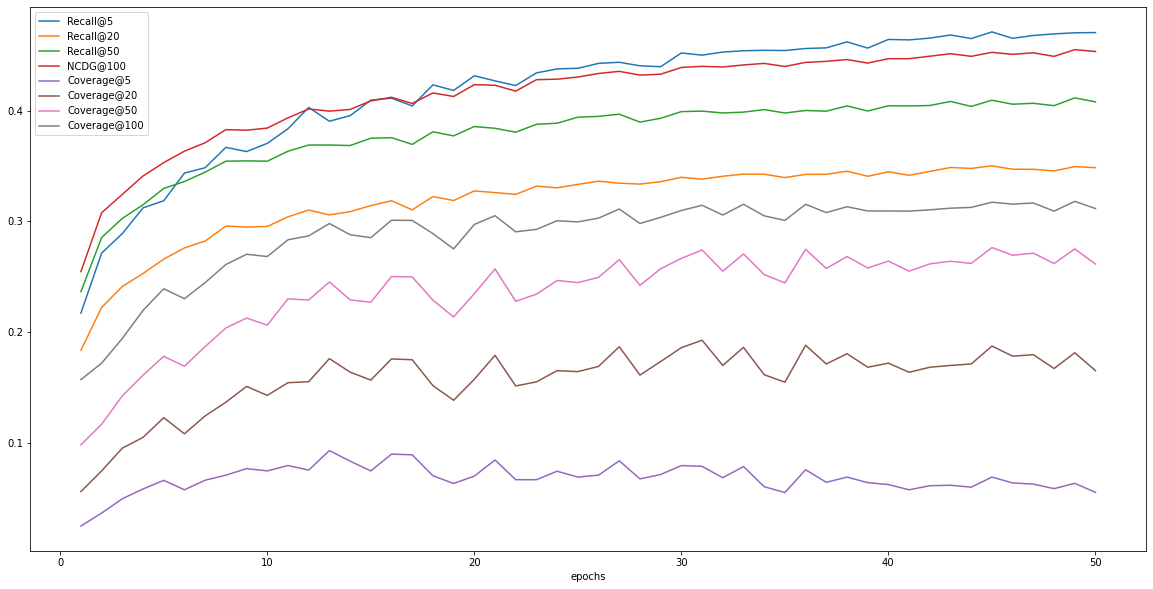

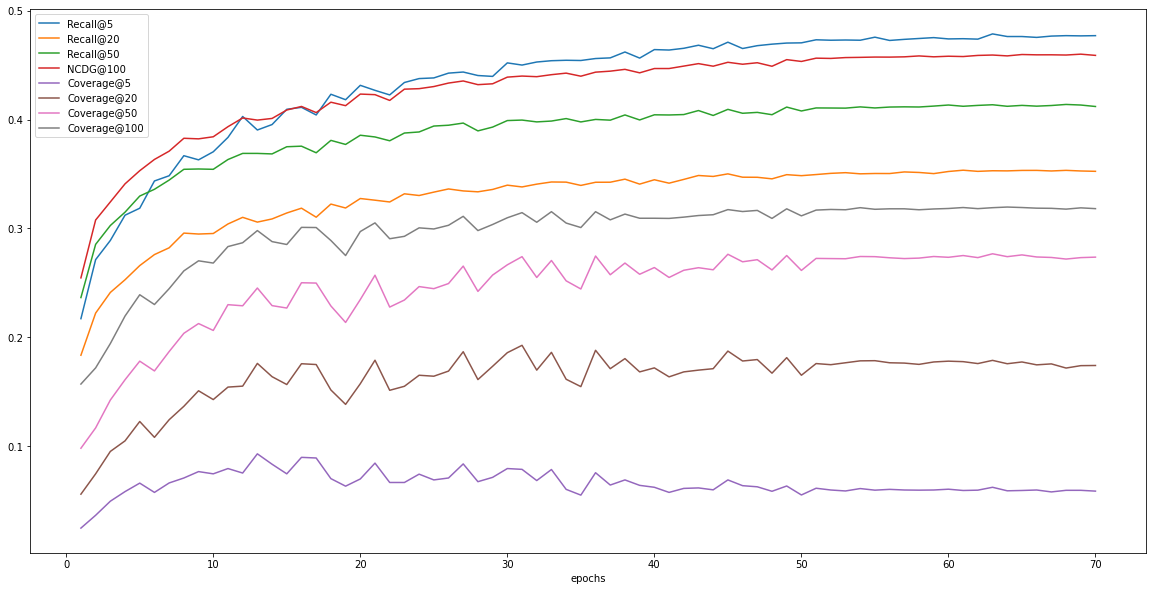

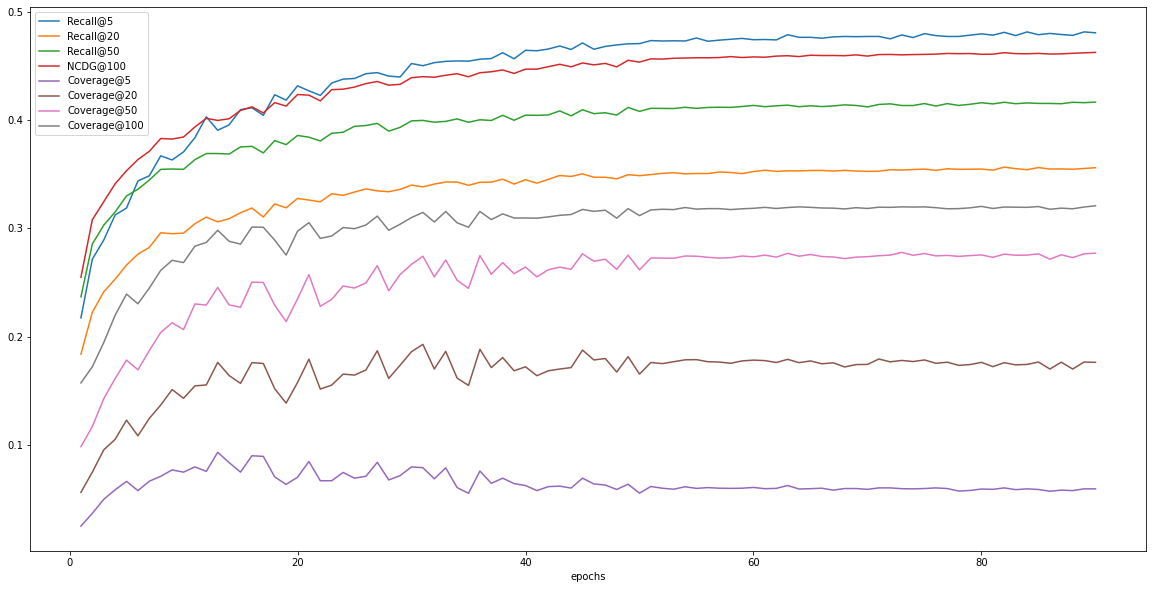

In [5]:
m = VASP(dataset.split, name="VASP_ML20_1")
m.create_model(latent=2048, hidden=4096, ease_items_sampling=0.33)
m.model.summary()
print("=" * 80)
print("Train for 50 epochs with lr 0.00005")
m.compile_model(lr=0.00005, fl_alpha=0.25, fl_gamma=2.0)
m.train_model(50)
print("=" * 80)
print("Than train for 20 epochs with lr 0.00001")
m.compile_model(lr=0.00001, fl_alpha=0.25, fl_gamma=2.0)
m.train_model(20)
print("=" * 80)
print("Than train for 20 epochs with lr 0.000001")
m.compile_model(lr=0.00001, fl_alpha=0.25, fl_gamma=2.0)
m.train_model(20)

Dataframe with the details of the training.

In [6]:
m.mc.get_history_df()

,epochs,Recall@5,Recall@20,Recall@50,NCDG@100,Coverage@5,Coverage@20,Coverage@50,Coverage@100
0,1,0.2172,0.183665,0.236575,0.254667,0.024974,0.056119,0.098281,0.157191
1,2,0.2714,0.222318,0.285422,0.307766,0.036727,0.074776,0.116938,0.172029
2,3,0.2890,0.241278,0.302714,0.324369,0.049655,0.095343,0.142500,0.194359
3,4,0.3122,0.252934,0.314966,0.340971,0.058469,0.105039,0.161158,0.219627
4,5,0.3186,0.265929,0.329757,0.353034,0.066255,0.122815,0.178199,0.239166
...,...,...,...,...,...,...,...,...,...
85,86,0.4798,0.354593,0.415158,0.460741,0.057147,0.169972,0.271338,0.317467
86,87,0.4788,0.354721,0.414899,0.460957,0.058175,0.176289,0.275452,0.318496
87,88,0.4780,0.354415,0.416236,0.461454,0.057735,0.169972,0.272807,0.317908
88,89,0.4812,0.355131,0.415872,0.461894,0.059351,0.176436,0.276333,0.319524


And the details of the training as a plot.

<AxesSubplot:xlabel='epochs'>

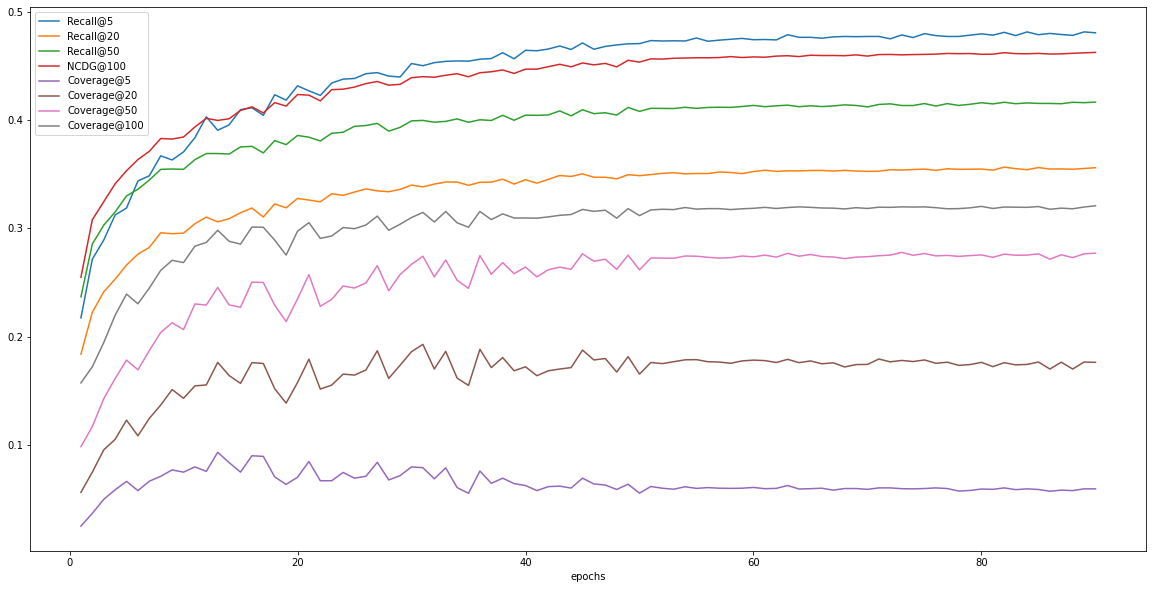

In [7]:
m.mc.plot_history()

For final evaluation we do 5-fold validation on the user's interaction history. We think that this is more objective measure than only hide sampled 20% of the user's interactions randomly.

In [8]:

class Evaluator2:
    """
    Evaluation on give data split.
    """

    def __init__(self, split, method='leave_random_20_pct_out', data="test", debug=False):
        assert method in ['leave_random_20_pct_out', '1_20', '2_20', '3_20', '4_20', '5_20', 'infer']
        self.split = split
        if data == "val":
            print("Creating validation split evaluator with", method, "method.")
            self.ivx = split.validation_gen.data.set_index(split.validation_gen.data.userid).sort_index().itemids.apply(
                lambda x: x.split(','))
        elif data == "infer":
            print("inference Start")
            self.ivx = split.inference_gen.data.set_index(split.inference_gen.data.userid).itemids.apply(
                lambda x: x.split(','))
        else:
            print("Creating test split evaluator with", method, "method.")
            self.ivx = split.test_gen.data.set_index(split.test_gen.data.userid).sort_index().itemids.apply(
                lambda x: x.split(','))
        if debug:
            print("Stage 1 done.")
        self.tpx = []
        if method == 'leave_random_20_pct_out':
            for e in range(len(self.ivx)):
                tech20 = []
                num_to_add = int(len(self.ivx[e]) * 0.2)
                if num_to_add < 1:
                    num_to_add = 1
                for x in range(num_to_add):
                    random_pick_index = randrange(len(self.ivx[e]))
                    tech20.append(self.ivx[e].pop(random_pick_index))
                self.tpx.append(tech20)
        elif method == 'infer':
            pass
        else:
            end = int(method[0])
            start = end - 1
            random.seed(get_seed())
            for e in range(len(self.ivx)):
                tech20 = []
                interactions_len = len(self.ivx[e])
                num_to_add = int(interactions_len * 0.2)
                if num_to_add < 1:
                    num_to_add = 1
                shuffle(self.ivx[e])
                for x in range(start * num_to_add, end * num_to_add):
                    random_pick_index = x
                    if random_pick_index >= len(self.ivx[e]):
                        random_pick_index = len(self.ivx[e]) - 1
                    tech20.append(self.ivx[e].pop(random_pick_index))
                self.tpx.append(tech20)

        if debug:
            print("Stage 2 done.")
        self.iv = self.split.master_data.toki.texts_to_matrix(
            [",".join(x) for x in self.ivx]
        )
        if debug:
            print("Stage 3 done.")
        self.tp = self.split.master_data.toki.texts_to_matrix(
            [",".join(x) for x in self.tpx]
        )
        self.tpx_set = [set(t) for t in self.tpx]
        if debug:
            print("Stage 4 done.")

    def update(self, m, chunk=1000):
        assert len(self.iv) % chunk == 0
        self.pr = np.vstack([m.predict(self.iv[chunk * x:chunk * (x + 1)]) for x in range(len(self.iv) // chunk)])
        self.ppp = (1 - self.iv) * self.pr
        self.ppp[:, 0] = 0
    
    def inference(self, m):
        self.pr = np.vstack([m.predict(self.iv)])
        self.ppp = (1 - self.iv) * self.pr
        self.ppp[:, 0] = 0

        idx = bn.argpartition(-self.ppp, 10, axis=1)
        topk_part = self.ppp[np.arange(self.ppp.shape[0])[:, np.newaxis], idx[:, :10]]
        idx_part = np.argsort(-topk_part, axis=1)
        idx_topk = idx[np.arange(self.iv.shape[0])[:, np.newaxis], idx_part]
        result = [[self.split.master_data.toki.index_word[b] for b in a] for a in idx_topk]
        return result

    def get_ncdg(self, k):
        pr = self.pr
        ppp = self.ppp
        idx = bn.argpartition(-ppp, k, axis=1)
        topk_part = ppp[np.arange(ppp.shape[0])[:, np.newaxis], idx[:, :k]]
        idx_part = np.argsort(-topk_part, axis=1)
        idx_topk = idx[np.arange(self.iv.shape[0])[:, np.newaxis], idx_part]
        tp = 1. / np.log2(np.arange(2, k + 2))
        z = zip([[self.split.master_data.toki.index_word[b] for b in a] for a in idx_topk], self.tpx_set)
        n = np.array([(np.array([1 if x in true else 0 for x in pred]) * tp).sum() for pred, true in z])
        d = np.array([(np.ones(min(k, len(x))) * tp[:len(x)]).sum() for x in self.tpx_set])
        return (n / d).mean()

    def get_hr(self, k):
        pr = self.pr
        ppp = self.ppp
        idx = bn.argpartition(-ppp, k, axis=1)
        z = zip([set([self.split.master_data.toki.index_word[s] for s in a[:k]]) for a in idx], self.tpx_set)
        r = [0 if len(pred & true) / min(k, len(true)) == 0 else 1 for pred, true in z]
        return sum(r) / len(r)

    def get_coverage(self, k):
        pr = self.pr
        ppp = self.ppp

        idx = bn.argpartition(-ppp, k, axis=1)
        covered = len(set().union(*[set([self.split.master_data.toki.index_word[s] for s in a[:k]]) for a in idx]))
        total = self.iv.shape[1] - 1
        return covered / total

    def get_recall(self, k):
        pr = self.pr
        ppp = self.ppp
        idx = bn.argpartition(-ppp, k, axis=1)
        z = zip([set([self.split.master_data.toki.index_word[s] for s in a[:k]]) for a in idx], self.tpx_set)
        r = [len(pred & true) / min(k, len(true)) for pred, true in z]
        return sum(r) / len(r)

    def ncdg(self, m, k):
        c = getattr(m, "pred_from_mean", None)
        if not callable(c):
            c = getattr(m, "predict", None)
        pr = c(self.iv)
        ppp = (1 - self.iv) * pr
        ppp[:, 0] = 0
        idx = bn.argpartition(-ppp, k, axis=1)
        topk_part = ppp[np.arange(ppp.shape[0])[:, np.newaxis], idx[:, :k]]
        idx_part = np.argsort(-topk_part, axis=1)
        idx_topk = idx[np.arange(self.iv.shape[0])[:, np.newaxis], idx_part]
        tp = 1. / np.log2(np.arange(2, k + 2))
        z = zip([[self.split.master_data.toki.index_word[b] for b in a] for a in idx_topk], self.tpx_set)
        n = np.array([(np.array([1 if x in true else 0 for x in pred]) * tp).sum() for pred, true in z])
        d = np.array([(np.ones(min(k, len(x))) * tp[:len(x)]).sum() for x in self.tpx_set])
        return (n / d).mean()

    def hr(self, m, k):
        c = getattr(m, "pred_from_mean", None)
        if not callable(c):
            c = getattr(m, "predict", None)
        pr = c(self.iv)
        ppp = (1 - self.iv) * pr
        ppp[:, 0] = 0
        idx = bn.argpartition(-ppp, k, axis=1)
        z = zip([set([self.split.master_data.toki.index_word[s] for s in a[:k]]) for a in idx], self.tpx_set)
        r = [0 if len(pred & true) / min(k, len(true)) == 0 else 1 for pred, true in z]
        return sum(r) / len(r)

    def coverage(self, m, k):
        c = getattr(m, "pred_from_mean", None)
        if not callable(c):
            c = getattr(m, "predict", None)
        pr = c(self.iv)
        ppp = (1 - self.iv) * pr
        ppp[:, 0] = 0
        idx = bn.argpartition(-ppp, k, axis=1)
        covered = len(set().union(*[set([self.split.master_data.toki.index_word[s] for s in a[:k]]) for a in idx]))
        total = self.iv.shape[1] - 1
        return covered / total

    def recall(self, m, k):
        c = getattr(m, "pred_from_mean", None)
        if not callable(c):
            c = getattr(m, "predict", None)
        pr = c(self.iv)
        ppp = (1 - self.iv) * pr
        ppp[:, 0] = 0
        idx = bn.argpartition(-ppp, k, axis=1)
        z = zip([set([self.split.master_data.toki.index_word[s] for s in a[:k]]) for a in idx], self.tpx_set)
        r = [len(pred & true) / min(k, len(true)) for pred, true in z]
        return sum(r) / len(r)

In [9]:
# 5-fold evaluation on the test set

test_r20s = []
test_r50s = []
test_n100s = []

for fold in range(1,6):
    ev=Evaluator(m.split, method=str(fold)+'_20')
    ev.update(m.model)

    test_n100s.append(ev.get_ncdg(100))
    test_r20s.append(ev.get_recall(20))
    test_r50s.append(ev.get_recall(50))

print("TEST SET (MEAN)")
print("5-fold mean NCDG@100", round(sum(test_n100s) / len(test_n100s),3))
print("5-fold mean Recall@20", round(sum(test_r20s) / len(test_r20s),3))
print("5-fold mean Recall@50", round(sum(test_r50s) / len(test_r50s),3))

Creating test split evaluator with 1_20 method.
Creating test split evaluator with 2_20 method.
Creating test split evaluator with 3_20 method.
Creating test split evaluator with 4_20 method.
Creating test split evaluator with 5_20 method.
TEST SET (MEAN)
5-fold mean NCDG@100 0.45
5-fold mean Recall@20 0.351
5-fold mean Recall@50 0.412


In [10]:
ev2 = Evaluator2(m.split, method='infer', data='infer')
result = ev2.inference(m.model)

inference Start


In [11]:
result

[['4886', '4370', '8961', '40815', '7438', '32587', '47', '2', '1779', '7373'],
 ['1198',
  '588',
  '1223',
  '4016',
  '4993',
  '919',
  '7153',
  '1073',
  '6539',
  '1028'],
 ['296',
  '1193',
  '2324',
  '46578',
  '5995',
  '4235',
  '56367',
  '8873',
  '33903',
  '63082'],
 ['1270', '47', '2762', '597', '1', '1206', '2997', '2329', '1073', '7153'],
 ['79132',
  '6377',
  '68954',
  '7454',
  '52722',
  '8644',
  '8360',
  '60040',
  '2628',
  '5882'],
 ['5952',
  '2959',
  '4963',
  '33794',
  '4306',
  '48516',
  '1',
  '4878',
  '48394',
  '480'],
 ['1197',
  '5952',
  '4993',
  '4973',
  '2858',
  '7153',
  '2762',
  '4963',
  '8961',
  '1196'],
 ['4993',
  '778',
  '4226',
  '527',
  '32587',
  '1089',
  '1258',
  '1704',
  '1214',
  '858'],
 ['2571', '50', '1198', '608', '150', '1183', '4995', '1090', '1258', '1089'],
 ['4973',
  '48394',
  '6539',
  '5618',
  '2571',
  '356',
  '1198',
  '1223',
  '46578',
  '4226'],
 ['2959',
  '4979',
  '2571',
  '56367',
  '356',
  '4

In [12]:
len(result)

31360

In [13]:
rating_df = pd.read_csv('/opt/ml/level2-movie-recommendation-level2-recsys-12/yonghoon/data/train/train_ratings.csv')
users = rating_df["user"].unique()

final = []
all_len = list()


    # top_movie = predict(movies, model, movie_to_idx, idx_to_movie)

In [14]:
len(users)

31360

In [17]:
print("test")

test


In [15]:

for i, user in enumerate(users):
    print(str(i) + "done")
    
    pred = result[i]
    for item in pred:
        final.append((user, item))

0done
1done
2done
3done
4done
5done
6done
7done
8done
9done
10done
11done
12done
13done
14done
15done
16done
17done
18done
19done
20done
21done
22done
23done
24done
25done
26done
27done
28done
29done
30done
31done
32done
33done
34done
35done
36done
37done
38done
39done
40done
41done
42done
43done
44done
45done
46done
47done
48done
49done
50done
51done
52done
53done
54done
55done
56done
57done
58done
59done
60done
61done
62done
63done
64done
65done
66done
67done
68done
69done
70done
71done
72done
73done
74done
75done
76done
77done
78done
79done
80done
81done
82done
83done
84done
85done
86done
87done
88done
89done
90done
91done
92done
93done
94done
95done
96done
97done
98done
99done
100done
101done
102done
103done
104done
105done
106done
107done
108done
109done
110done
111done
112done
113done
114done
115done
116done
117done
118done
119done
120done
121done
122done
123done
124done
125done
126done
127done
128done
129done
130done
131done
132done
133done
134done
135done
136done
137done
138don

In [16]:
pd.DataFrame(final, columns=["user", "item"]).to_csv(
    "vasp_submission_upgrade.csv", index=False
)